# Determining the Equilibrium Geometry of H₂ with VQE

In the previous section I used VQE to estimate the ground-state energy of a fixed-geometry molecule.  
In this notebook, I extend that workflow to **molecular structure** by scanning the **H–H bond length** and identifying the geometry that minimizes the total energy.

## Step 1 — Map a classical geometry parameter to a quantum problem

For diatomic hydrogen (H₂), the only geometric degree of freedom is the **internuclear distance** \(R\).  
The key change from the fixed-geometry example is that I treat \(R\) as an input variable and rebuild the molecular Hamiltonian for each value of \(R\). That dependence starts at the electronic-structure (fermionic) Hamiltonian and propagates through the mapping to qubits and into the VQE cost function.

In [22]:
import qiskit
import qiskit_ibm_runtime
 
print(qiskit.version.get_version_info())
print(qiskit_ibm_runtime.version.get_version_info())

2.2.2
0.41.1


## Imports and helper functions

I reuse the same core utilities as the previous section:

- A **Cholesky decomposition** routine for factorizing two-electron integrals (used to make Hamiltonian construction more efficient).
- Convenience functions for building the **identity operator** and the **Jordan–Wigner creation/annihilation operators** as qubit (Pauli) operators.


In [23]:
# Loading packages we used before and defining Choleskey Function

from qiskit.quantum_info import SparsePauliOp
import matplotlib.pyplot as plt
import numpy as np
 
#!pip install pyscf==2.4.0
from pyscf import ao2mo, gto, mcscf, scf
 
 
def cholesky(V, eps):
    # see https://arxiv.org/pdf/1711.02242.pdf section B2
    # see https://arxiv.org/abs/1808.02625
    # see https://arxiv.org/abs/2104.08957
    no = V.shape[0]
    chmax, ng = 20 * no, 0
    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    print(
        "accuracy of Cholesky decomposition ",
        np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    )
    return L, ng
 
 
def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])
 
 
def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                ell, r = "I" * (n - 1), ""
            elif p == n - 1:
                ell, r = "", "Z" * (n - 1)
            else:
                ell, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(ell + "X" + r, 0.5), (ell + "Y" + r, -0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list

## Building a geometry-dependent Hamiltonian with PySCF

To study how molecular geometry affects the energy, I now define the electronic Hamiltonian as a **function of the H–H bond length**.  
Compared to the fixed-geometry case, the only change is that the interatomic distance is treated as an input variable.

For each value of the bond length \(x\), I:
1. Build the H₂ molecular geometry in PySCF
2. Run a Hartree–Fock calculation
3. Perform a CASCI calculation in the active space
4. Extract the effective one- and two-electron integrals

These quantities are later mapped to a qubit Hamiltonian and used in the VQE cost function.


In [24]:
def ham_terms(x: float):
    distance = x
    a = distance / 2
    mol = gto.Mole()
    mol.build(
        verbose=0,
        atom=[
            ["H", (0, 0, -a)],
            ["H", (0, 0, a)],
        ],
        basis="sto-6g",
        spin=0,
        charge=0,
        symmetry="Dooh",
    )
 
    # mf = scf.RHF(mol)
    # mx = mcscf.CASCI(mf, ncas=2, nelecas=(1, 1))
    # mx.kernel()
 
    mf = scf.RHF(mol)
    mf.kernel()
    if not mf.converged:
        raise RuntimeError(f"SCF did not converge for distance {x}")
 
    mx = mcscf.CASCI(mf, ncas=2, nelecas=(1, 1))
    casci_energy = mx.kernel()
    if casci_energy is None:
        raise RuntimeError(f"CASCI failed for distance {x}")
 
    # Other variables that might come in handy:
    # active_space = range(mol.nelectron // 2 - 1, mol.nelectron // 2 + 1)
    #    E1 = mf.kernel()
    # mo = mx.sort_mo(active_space, base=0)
    #    E2 = mx.kernel(mo)[:2]
 
    h1e, ecore = mx.get_h1eff()
    h2e = ao2mo.restore(1, mx.get_h2eff(), mx.ncas)
    return ecore, h1e, h2e

## Mapping the (fermionic) molecular Hamiltonian to qubits

PySCF gives me the effective active-space Hamiltonian in second-quantized (fermionic) form through the one- and two-electron integrals.  
To run VQE, I need an operator acting on qubits, so in this step I map the fermionic Hamiltonian to a **qubit Hamiltonian expressed as a sum of Pauli strings** (a `SparsePauliOp`).

I keep the bond length as an input variable so the Hamiltonian can be rebuilt for each geometry during the bond-length scan.


In [25]:
def build_hamiltonian(distx: float) -> SparsePauliOp:
    ecore = ham_terms(distx)[0]
    h1e = ham_terms(distx)[1]
    h2e = ham_terms(distx)[2]
 
    ncas, _ = h1e.shape
 
    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r]
                + C[ncas + p] @ D[ncas + r]
                + C[r] @ D[p]
                + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)
 
    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)
 
    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg
 
    return H.chop().simplify()

## VQE setup: ansatz, optimizer, and runtime access

With the Hamiltonian now defined in qubit form, I next load the components required to run VQE:

- A **parameterized ansatz circuit** (`EfficientSU2`) to generate trial quantum states
- A **classical optimizer** from SciPy to minimize the VQE cost function
- IBM Quantum Runtime tools to allow execution on simulators or real hardware

At this stage, I am only setting up the tools; the full VQE loop is constructed in the following sections.


In [26]:
# General imports
 
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp
 
# SciPy minimizer routine
from scipy.optimize import minimize
 
# Plotting functions
 
# Qiskit Runtime tools
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()

## Defining the VQE cost function

The VQE cost function computes the expectation value  
⟨ψ(θ)| H |ψ(θ)⟩ for a given set of variational parameters.

Because the Hamiltonian is already fully constructed and mapped to the device layout before being passed in, the structure of the cost function itself does not change. It simply prepares the ansatz with a given parameter vector and evaluates the energy using a Qiskit estimator primitive.


In [27]:
def cost_func(params, ansatz, H, estimator):
    pub = (ansatz, [H], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    return energy
 
 
# def cost_func_sim(params, ansatz, H, estimator):
#    energy = estimator.run(ansatz, H, parameter_values=params).result().values[0]
#    return energy

## Step 2 — Optimizing the problem for quantum execution

Because the molecular Hamiltonian changes with geometry, the compiled (hardware-ready) form of the circuit also changes at each bond length.  
However, the *transpilation strategy itself* can be defined once and reused, since it depends only on the target hardware rather than on the specific molecular geometry.

Instead of selecting the least-busy backend dynamically, I explicitly target the **IBM Quantum Nighthawk R1 processor**, which was introduced at the IBM Quantum Developer Conference (QDC). Anchoring the workflow to a specific, well-characterized hardware architecture ensures consistency across all geometry points and avoids backend-to-backend variability in the results.

I then use this real device as a template for an `AerSimulator`, allowing the simulator to inherit the device’s qubit connectivity, gate set, and noise characteristics. While these noise models are approximate, they provide a more realistic indication of expected hardware behavior than an ideal, noiseless simulator.


In [33]:
# My confidential credentials (CRN and access token) have been removed
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService(channel="ibm_cloud", instance="crn:", token="")


In [44]:
backend = service.backend("ibm_miami")
print(backend)
cfg = backend.configuration()
cfg_dict = cfg.to_dict() if hasattr(cfg, "to_dict") else cfg.__dict__

print("processor_type:", cfg_dict.get("processor_type"))


<IBMBackend('ibm_miami')>
processor_type: {'family': 'Nighthawk', 'revision': '1'}


In [12]:
# To run on a simulator:
# -----------
from qiskit_aer import AerSimulator
 
backend_sim = AerSimulator.from_backend(backend)

## Circuit transpilation and noise-mitigation strategy

To prepare circuits for execution on real hardware (or a hardware-faithful simulator), I define a hardware-specific transpilation and scheduling strategy using Qiskit’s pass manager infrastructure.

This step is independent of the molecular Hamiltonian itself. Once the target device is fixed, the same pass manager can be applied consistently to all ansatz circuits generated during the geometry scan.


In [21]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
    ConstrainedReschedule,
)
from qiskit.circuit.library import XGate
 
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)

## Step 3 — Executing VQE with Qiskit primitives

In this step, I execute the VQE workflow across a range of H–H bond lengths in order to construct an approximate potential energy curve for H₂.

I define a grid of interatomic distances centered around the experimentally known equilibrium bond length (~0.74 Å). For each geometry, I rebuild the Hamiltonian, compile the ansatz for the target hardware, and run a classical optimization loop to minimize the VQE energy.

All calculations in this section are performed on a hardware-faithful simulator using Qiskit’s `BackendEstimatorV2`. For each bond length, I store both the **total energy** and the **electronic energy** (with the nuclear repulsion term removed).  

Because VQE optimization can be computationally expensive, the optimizer settings (number of iterations, step size, etc.) can be adjusted to trade off accuracy against runtime.


In [15]:
#simulator
from qiskit.primitives import BackendEstimatorV2
 
estimator = BackendEstimatorV2(backend=backend_sim)
 
distances_sim = np.arange(0.3, 1.3, 0.1)
vqe_energies_sim = []
vqe_elec_energies_sim = []
 
for dist in distances_sim:
    xx = dist
 
    # Random initial state and efficient_su2 ansatz
    H = build_hamiltonian(xx)
    ansatz = efficient_su2(H.num_qubits)
    ansatz_isa = pm.run(ansatz)
    x0 = 2 * np.pi * np.random.random(ansatz_isa.num_parameters)
    H_isa = H.apply_layout(ansatz_isa.layout)
    nuclear_repulsion = ham_terms(xx)[0]
 
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, H_isa, estimator),
        method="cobyla",
        options={"maxiter": 20, "disp": True},
    )
 
    # Note this returns the total energy, and we are often interested in the electronic energy
    tot_energy = getattr(res, "fun")
    electron_energy = getattr(res, "fun") - nuclear_repulsion
    print(electron_energy)
    vqe_energies_sim.append(tot_energy)
    vqe_elec_energies_sim.append(electron_energy)
 
    # Print all results
    print(res)
 
print("All energies have been calculated")

accuracy of Cholesky decomposition  1.1102230246251565e-15
Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 34   Least value of F = 0.5361573474230283
The corresponding X is:
[3.24155482 7.13817286 2.64110269 2.38691323 0.33705028 1.33767354
 5.50545026 5.47252666 0.12064645 3.32870662 2.61832466 3.13770109
 3.5410438  1.86295022 4.3471186  2.94900976 2.72990135 5.97163052
 3.13665187 5.40322021 6.20214572 5.20919342 4.72131009 3.4685439
 2.99627865 3.07396272 5.7508508  1.10498002 1.8388849  0.20971967
 5.59818124 0.47188099]

-1.2277666889769718
 message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
 success: False
  status: 3
     fun: 0.5361573474230283
       x: [ 3.242e+00  7.138e+00 ...  5.598e+00  4.719e-01]
    nfev: 34
   maxcv: 0.0
accuracy of Cholesky decomposition  5.551115123125783e-16
Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number

## Step 4 — Post-processing and interpretation of results

Using the simulator-backed VQE results, I plot the estimated ground-state energy of H₂ as a function of the H–H bond length. The minimum of this curve provides an estimate of the equilibrium bond length predicted by the variational quantum workflow.

In my simulation, the lowest energy is observed at a bond length of approximately **0.80 Å**, whereas the experimentally known equilibrium bond length of H₂ is **~0.74 Å**. Similarly, the minimum total energy obtained here is approximately **−0.7 Hartree**, compared to the exact ground-state energy of **−1.17 Hartree**.

This discrepancy is expected and reflects several known limitations of near-term VQE simulations:


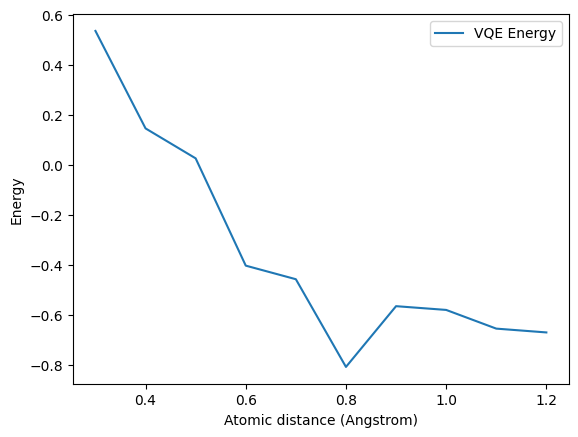

In [16]:
# Here we can plot the results from this simulation.
plt.plot(distances_sim, vqe_energies_sim, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

- **Basis set limitations**  
  The STO-6G basis is minimal and is known to shift both equilibrium geometries and absolute energies.

- **Ansatz expressibility**  
  The hardware-efficient `EfficientSU2` ansatz is not chemistry-informed and may not capture correlation equally well across all geometries, leading to a shifted minimum.

- **Optimization truncation**  
  The classical optimizer was intentionally limited in iteration count to keep runtime manageable. Incomplete convergence affects both the depth of the energy minimum and its position.

- **Discrete geometry sampling**  
  Bond lengths were sampled in steps of 0.1 Å, so the apparent minimum at 0.80 Å may be a grid artifact rather than the true continuous minimum.

- **Noise-aware execution**  
  The simulator mimics device noise, but no explicit error mitigation was applied in this workflow. This further biases energy estimates upward.


Despite these approximations, the resulting potential energy curve correctly reproduces the qualitative physics of the H₂ molecule:
- The existence of a well-defined energy minimum
- Increasing energy at both short (repulsive) and long (dissociative) bond lengths
- A predicted equilibrium geometry that is reasonably close to the experimental value

These results demonstrate how a geometry-dependent Hamiltonian, combined with VQE, can be used to explore molecular structure within the constraints of near-term quantum algorithms.


Future improvements could include using a chemistry-inspired ansatz (e.g., UCC-type circuits), increasing optimizer convergence, refining the bond-length grid, and applying explicit error mitigation. These steps are expected to systematically improve both the predicted equilibrium bond length and the absolute energy.
